# Hybrid Classic-Quantum Systems - Third Assignment #

You should fill in this Jupyter notebook in order to complete the assignment. Here a small recap of the rules:

* You should **NOT** modify the functions that are already provided in the notebook, unless it is strictly necessary;
* If you want to modify the given functions, please, provide an explanation of why you had to;
* You can define new functions, as soon as they are well commented;
* You can import all libraries you want, as soon as you justify their utilization;
* You can add new cells, as soon as you do not remove the cells where you are supposed to comment your solution;
* This is a group assignment. The maximum number of people is 3;
* Your solution should be commented and accompanied by a small description - you can add additional cells if needed;
* For any issue and doubt, please do not hesitate to use the forum or to write me an email.

# Preliminaries #

## Bin Packing Problem (BPP) ##
The bin packing problem (BPP) is an optimization problem. The final goal is to fit items of different sizes into a finite number of bins, each of a fixed given capacity, minimizing the number of bins used. The problem has many applications, ranging from logistics, multi-processor scheduling.

Computationally, the problem is NP-hard, and the corresponding decision problem, deciding if items can fit into a specified number of bins, is NP-complete.
![np-complete](https://imgs.xkcd.com/comics/np_complete.png)

## Mathematical formulation ##
The objective function of BPP is to minimize the number of bins used, more formally,
\begin{align} \label{eqn:bpp}
    & {\min}
    & &  \sum_{j=1}^{K} B_j \\
    & {\text{subject to}}
    & & g(x_{ij}) = \sum_{j=1}^{K} x_{ij} = 1 \qquad \forall i \\
    & & & h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} \le C*B_j \qquad \forall j
\end{align}

# Loading BPP instances #
First of all, we focus on generating instances of BPP to be used for the evaluation. Each instance is structured in the following way:

$[[w_0, w_1, ..., w_n], C, B, items]$, such that:
* $w_i$ is the weight of item $i$;
* $C$ is the capacity of each bin;
* $B$ is the number of bins;
* $items$ is the number of items

We pre-generated the instances for you and saved them in an attached binary file. You can read them in your code by using the following code:

In [69]:
!pip install numpy


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [70]:
import pickle


def read_list(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

The constraint $g(x)$ implies that each task can be packed into at most one CPU, and constraint $h(x_{ij})$ says that the requirements of each task can not exceed the given $C$ capacity. In this paper, BPP can be considered as a mixture of inequality and equality-constrained optimization problems.

In [71]:
from math import gcd
from functools import reduce
def smallest_denominator(instances):
    processed = []

    for ins in instances:
        weights, C, B, items = ins

        while True:
            # Finding the GCD of all weights and the capacity
            all_values = weights + [C]
            smallest_denominator = reduce(gcd, all_values)

            if smallest_denominator <= 1:
                break  # Exit the loop if the GCD is 1

            # Dividing weights and capacity by the smallest denominator
            weights = [w // smallest_denominator for w in weights]
            C = C // smallest_denominator
        processed.append([weights, C, B, items])
    return processed


In [72]:
from itertools import combinations

def best_space_util(instances):
    processed = []
    for ins in instances:
        weights, C, B, items = ins

        # Initialize variables to track the best pair and minimum remaining capacity
        best_pair = None
        min_remaining_capacity = C
        additional_weight = None

        # Iterate through all pairs of weights
        for pair in combinations(weights, 2):
            combined_weight = sum(pair)
            remaining_capacity = C - combined_weight

            # Update best_pair and min_remaining_capacity if this pair is better
            if 0 <= remaining_capacity < min_remaining_capacity:
                min_remaining_capacity = remaining_capacity
                best_pair = pair

        # Check for an additional weight that can be added to the best pair
        if best_pair:
            for weight in weights:
                if weight not in best_pair and sum(best_pair) + weight <= C:
                    # Ensure no other weight can be added with this additional weight
                    if all(w + sum(best_pair) + weight > C for w in weights if w not in best_pair):
                        additional_weight = weight
                        break

        # Combine the best pair and additional weight into a single item or keep the weights as is if no pair found
        if best_pair:
            new_weights = weights.copy()
            # Remove the elements of the pair
            new_weights.remove(best_pair[0])
            new_weights.remove(best_pair[1])
            # Add the combined weight of the pair
            combined_weight = sum(best_pair)
            if additional_weight:
                new_weights.remove(additional_weight)
                combined_weight += additional_weight
                new_items = items - 2  # Reduce items by 2 as three weights are combined into one
            else:
                new_items = items - 1  # Reduce items by 1 as two weights are combined into one
            new_weights.append(combined_weight)
            processed.append([new_weights, C, B, new_items])
        else:
            processed.append([weights, C, B, items])

    return processed



In [73]:
def remove_bucket_if_item_is_big(instances):
    processed = []
    for ins in instances:
        weights, C, B, items = ins
        biggest_item = max(weights)
        smallest_item = min(weights)
        if biggest_item + smallest_item > C:
            # Remove the bucket
            new_B = B - 1
            new_weights = weights.copy()
            # Remove the biggest item
            new_weights.remove(biggest_item)
            new_items = items - 1
            processed.append([new_weights, C, new_B, new_items])
        else:
            processed.append([weights, C, B, items])
    return processed

In [74]:
def preprocess_instances(instances):
    space_util = best_space_util(instances)
    better_buckets = remove_bucket_if_item_is_big(space_util)
    reduced_weight = smallest_denominator(better_buckets)
    return reduced_weight

# Transforming BPP into a QUBO #
QUBO is a mathematical model that is used to represent combinatorial optimization problems in which the variables are binary $\{0,1\}$ and the objective function with constraints is quadratic. We employ QUBO for BPP because it provides a framework for representing combinatorial optimization problems in a form that can be efficiently solved using quantum computing algorithms designed for QUBO problems, such as VQE or QAOA.

## Slack Variables + Quadratic Penalty Encoding ##
Qiskit Optimization provides with QuadraticProgram a very generic and powerful representation for optimization problems. However, usually, optimization algorithms cannot handle all possible types of problems that can be modelled, but only a sub-class. Many available quantum optimization algorithms can handle Quadratic Unconstrained Binary Optimization (QUBO) problems. To do so, first, it is necessary to convert a given optimization problem into a QUBO.

Qiskit Optimization provides converters to achieve this conversion whenever possible. More precisely, Qiskit Optimization provides the following converters:
* *InequalityToEquality*: converts inequality constraints into equality constraints with additional slack variables.
* *IntegerToBinary* : converts integer variables into binary variables and corresponding coefficients.
* *LinearEqualityToPenalty* : convert equality constraints into additional terms of the object function.
* *QuadraticProgramToQubo* : a wrapper for IntegerToBinary and LinearEqualityToPenalty for convenience.
More information available at: https://qiskit.org/documentation/stable/0.19/tutorials/optimization/2_converters_for_quadratic_programs.html

## Penalty-Based Encoding ##

### Define penalties ###
To enforce the constraints, we introduce penalty terms to the objective function. These terms penalize solutions that violate the constraints. Firsts, we rewrite constraints $g(x_{ij})$ and $h(x_{ij})$ as follows,
     \begin{align*}
        g(x_{ij}) = \sum_{j=1}^{K} x_{ij} - 1 = 0 \qquad \forall i \\
        h(x_{ij}) = \sum_{i=1}^N w_{i}x_{ij} - C \cdot B_j \le 0 \qquad \forall j \\
    \end{align*}
    Second, introduce penalty functions $p_1(\lambda, g(x))$ and $p_2(\beta, h(x))$ with coefficients $\{\lambda, \beta\} \geq 0 $
    \begin{equation}\label{penalty1}
        p_1(\lambda, g(x_{ij})) =
        \begin{cases}
            0 & \text{if $g(x_{ij}) \leq 0$} \\
            \lambda g(x_{ij}) & \text{if $g(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    \begin{equation}\label{penalty2}
        p_2(\beta, h(x_{ij})) =
        \begin{cases}
            0 & \text{if $h(x_{ij}) \leq 0$} \\
            \beta h(x_{ij}) & \text{if $h(x_{ij}) > 0$}
        \end{cases}
    \end{equation}
    
In literature, there are multiple methods for penalization such as the exterior penalty function and interior penalty function.

### Injecting Penalties in the Model ###
To get the final QUBO form we combine penalties with objective function and get

\begin{equation}
    \mathcal{F} = \sum_{j=1}^{K} B_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}

### Examples of penalty functions ###
* https://www.stat.cmu.edu/~ryantibs/convexopt-F13/scribes/lec16.pdf
* https://www.rose-hulman.edu/~bryan/lottamath/penalty.pdf

## YOUR TASK ##
* Apply slack + quadratic penalty
* Apply penalty-based encoding using three functions

In [75]:
# needs to installed before other qiskit packages to avoid dependency issues
!pip install qiskit-aqt-provider


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [76]:
!pip install qiskit-optimization


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [77]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, InequalityToEquality, \
    IntegerToBinary


def quadratic_penalty(instance):
    # Extract instance data
    weights, C, B, items = instance

    # Create a Quadratic Program
    qp = QuadraticProgram()


    for j in range(B):
        qp.binary_var(name=f'B_{j}')

    for i in range(items):
        for j in range(B):
            # Skip creating a variable for the first item in non-first bins
            if i == 0 and j != 0:
                continue
            qp.binary_var(name=f'x_{i}_{j}')

    # Objective function: Minimize the number of bins used
    # This is done by minimizing the sum of B_j, where B_j = 1 if bin j is used
    qp.minimize(linear=[1] * B)

    eq_to_pen = LinearEqualityToPenalty(100)
    # Constraint g(x): Each item i must be in exactly one bin
    for i in range(items):
        qp.linear_constraint(
            linear={f'x_{i}_{j}': 1 for j in range(B) if not (i == 0 and j != 0)},
            sense='==',
            rhs=1,
            name=f'item_in_one_bin_{i}')
        qp = eq_to_pen.convert(qp)
    neq_to_eq = InequalityToEquality("integer")
    eq_to_pen2 = LinearEqualityToPenalty(200)
    int_to_bin = IntegerToBinary()
    # Constraint h(x): Total weight in each bin j must not exceed its capacity C
    for j in range(B):
        # Create a dictionary for the linear terms
        linear_terms = {f'x_{i}_{j}': weights[i] for i in range(items) if not (i == 0 and j != 0)}
        # Add the term for B_j with a negative coefficient
        linear_terms[f'B_{j}'] = -C
        qp.linear_constraint(
            linear=linear_terms,
            sense='<=',
            rhs=0,  # Set the RHS to 0
            name=f'bin_capacity_{j}')
        qp = neq_to_eq.convert(qp)
        qp = int_to_bin.convert(qp)
        qp = eq_to_pen2.convert(qp)
    return qp

# Encoding QUBO into ISING Hamiltonian #
The next step is to encode the classical QUBO formulation into a quantum state. There exist techniques to encode classical data into quantum such as basis encoding, amplitude encoding, and angle encoding. In this paper, we apply basis encoding, for which any quantum basis can be chosen, but the common way for doing so is to choose basis $\{-1,1\}$ as follows:
\begin{align}
\label{eqn:to_ising}
    \begin{split}
    x_i = \frac{1-z_i}{2}\\
    z_i*z_j = \sigma_Z^i \otimes \sigma_Z^j \\
    z_i = \sigma_Z^i
    \end{split}
\end{align}
where $\sigma_Z^i$ denotes the Pauli-Z matrix
$\begin{pmatrix}
  1 & 0\\
  0 & -1
\end{pmatrix}$ on the $i$-th qubit.
The eigenvalues of $\text{I} - \frac{Z}{2}$ are $\{-1,1\}$ with corresponding eigenstates $|0\rangle$ and $|1\rangle$. Thus, we switch from Z to $\text{I} - \frac{Z}{2}$, and rewrite the problem as BPP Ising hamiltonian,
\begin{equation} \label{eqn:final_hamiltonian}
    H_{bpp}= \sum_{j=1}^{K} \sigma_j + \sum_{j=1}^{K}p_1(\lambda, g_j) + \sum_{i=1}^{N}p_2(\beta,h_i)
\end{equation}
where $g_j$ and $h_i$ are now functions of $\sigma$.

## YOUR TASK: Encoding the QUBO as an Ising Hamiltonian ##


With the quadratic penalty encoding quskit automatically converts the QUBO into an Ising Hamiltonian when using the QAOA algorithm
for demonstrations show how to convert the QUBO into an Ising Hamiltonian and back

In [78]:
import os


def is_colab_env():
    return 'COLAB_GPU' in os.environ

In [79]:
if is_colab_env():
    from google.colab import drive

    drive.mount('/content/drive', force_remount=True)
    %cd /content/drive/My Drive/Data Set/HCQ

In [80]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import LinearEqualityToPenalty, InequalityToEquality, \
    IntegerToBinary


def quadratic_penalty(instance):
    # Extract instance data
    weights, C, B, items = instance

    # Create a Quadratic Program
    qp = QuadraticProgram()


    for j in range(B):
        qp.binary_var(name=f'B_{j}')

    for i in range(items):
        for j in range(B):
            qp.binary_var(name=f'x_{i}_{j}')

    # Objective function: Minimize the number of bins used
    # This is done by minimizing the sum of B_j, where B_j = 1 if bin j is used
    qp.minimize(linear=[1] * B)

    eq_to_pen = LinearEqualityToPenalty(100)
    # Constraint g(x): Each item i must be in exactly one bin
    for i in range(items):
        qp.linear_constraint(
            linear={f'x_{i}_{j}': 1 for j in range(B)},
            sense='==',
            rhs=1,
            name=f'item_in_one_bin_{i}')
        qp = eq_to_pen.convert(qp)
    neq_to_eq = InequalityToEquality("integer")
    eq_to_pen2 = LinearEqualityToPenalty(200)
    int_to_bin = IntegerToBinary()
    # Constraint h(x): Total weight in each bin j must not exceed its capacity C
    for j in range(B):
        # Create a dictionary for the linear terms
        linear_terms = {f'x_{i}_{j}': weights[i] for i in range(items)}
        # Add the term for B_j with a negative coefficient
        linear_terms[f'B_{j}'] = -C
        qp.linear_constraint(
            linear=linear_terms,
            sense='<=',
            rhs=0,  # Set the RHS to 0
            name=f'bin_capacity_{j}')
        qp = neq_to_eq.convert(qp)
        qp = int_to_bin.convert(qp)
        qp = eq_to_pen2.convert(qp)
    return qp

# Solving BPP instances #
Solve each problem instances using different methods:
## CPLEX optimizer ##
Classic optimizer, to be used as baseline with all the others.

In [81]:
if os.getenv("CUSTOM_MAC_ENV"):
    !python ~/Applications/CPLEX_Studio_Community2211/python/setup.py install
else:
    !pip install qiskit-optimization[cplex]

Invoking ['/Users/paulpinter/Repository/hybrid-quantum-ass3/venv/bin/python', '-m', 'pip', 'install', '.'] in /Users/paulpinter/Applications/CPLEX_Studio_Community2211/cplex/python/3.9/arm64_osx
Processing /Users/paulpinter/Applications/CPLEX_Studio_Community2211/cplex/python/3.9/arm64_osx
  Preparing metadata (setup.py) ... done
  Created wheel for cplex: filename=cplex-22.1.1.0-py3-none-any.whl size=8153295 sha256=641110f624b10ea4a9f238e14d2ac183a22eb271a81cfc7f4f7cc6cdd283ab19
  Stored in directory: /private/var/folders/6l/zlnf9sw956d63h7tczx2cqv00000gn/T/pip-ephem-wheel-cache-lf960cqt/wheels/1d/cd/cd/a559b6d9c297ea89fe811bf256b1066cc5e0e02508337d4277
Successfully built cplex
  Attempting uninstall: cplex
    Found existing installation: cplex 22.1.1.0
    Uninstalling cplex-22.1.1.0:
      Successfully uninstalled cplex-22.1.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Invoking ['/Users/paulpinter/Repository/hy

In [82]:
!pip install pandas


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [83]:
def create_instance_df(instances):
    instance_file = 'instance_data.csv'
    instance_df = pd.DataFrame(columns=['id', 'weights', 'capacity', 'bins', 'items', 'number_var'])
    prep = preprocess_instances(instances)
    for idx, ins in enumerate(instances):
        bp = quadratic_penalty(prep[idx])
        instance_df.loc[idx] = [idx, ins[0], ins[1], ins[2], ins[3], bp.get_num_vars()]
    instance_df.to_csv(instance_file, index=False)

In [84]:
from qiskit_optimization.algorithms import CplexOptimizer
from time import time


def create_classical_df(instances):
    classical_file = 'classical_data.csv'
    classical_df = pd.DataFrame(columns=['id', 'instance_id', 'optimum', 'time'])
    for idx, ins in enumerate(instances):
        bp = quadratic_penalty(ins)
        cplex_solver = CplexOptimizer()
        start_time = time()
        result = cplex_solver.solve(bp)
        end_time = time()
        execution_time = end_time - start_time
        classical_df.loc[idx] = [idx, idx, result.fval, execution_time]
    classical_df.to_csv(classical_file, index=False)

## QAOA solution ##

In [85]:
!pip install qiskit-algorithms


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [86]:
if is_colab_env():
    print("Running on Google Colab. Installing qiskit-aer-gpu...")
    %pip install qiskit-aer-gpu
else:
    print("Not running on Google Colab. Installing qiskit-aer...")
    %pip install qiskit-aer

Not running on Google Colab. Installing qiskit-aer...

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [87]:
from qiskit import Aer
from qiskit.primitives import BackendSampler


def aer_sampler(shots):
    backend = Aer.get_backend('aer_simulator')
    if is_colab_env():
        backend.set_options(device='GPU', shots=shots)
    else:
        backend.set_options(shots=shots)
    return BackendSampler(backend=backend)

In [88]:
from qiskit_aer.noise import NoiseModel, phase_damping_error


def noisy_sampler(shots):
    noise_model = NoiseModel()
    # Phase damping error
    p_phase_damping = 0.05
    phase_damping = phase_damping_error(p_phase_damping)
    noise_model.add_all_qubit_quantum_error(phase_damping, 'z')
    backend = Aer.get_backend('aer_simulator')
    if is_colab_env():
        backend.set_options(device='GPU', shots=shots, noise_model=noise_model)
    else:
        backend.set_options(shots=shots, noise_model=noise_model)
    return BackendSampler(backend=backend)

In [89]:
from qiskit_aqt_provider import AQTProvider
from qiskit_aqt_provider.primitives import AQTSampler


def aqt_sampler(shots):
    aqt = AQTProvider("ACCESS_TOKEN")
    backend = aqt.get_backend('offline_simulator_no_noise')
    backend.set_options(shots=shots)
    return AQTSampler(backend=backend)

In [90]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 10598

In [91]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.minimum_eigensolvers import QAOA


def solve_qaoa(sampler, reps, optimizer):
    qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
    solver = MinimumEigenOptimizer(qaoa_mes)
    return solver

## Warm start QAOA ##

In [92]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer


def solve_qaoa_warm_start(sampler, optimizer, reps):
    qaoa_mes = QAOA(sampler=sampler, reps=reps, optimizer=optimizer)
    solver = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(),
                                    relax_for_pre_solver=True,
                                    qaoa=qaoa_mes)
    return solver

# Evaluation #

Evaluate quantum solutions in comparison with classic solution using the following metrics:
* Running time;
* Mean square error between quantum optimum and classic optimum;
* Number of times each algorithm reaches the optimum;

Evaluation should be performed on the following backends:
* Noiseless simulator (Aer)
* Noisy simulator (choose a noise model)
* BONUS: test on AQT simulator (check https://github.com/qiskit-community/qiskit-aqt-provider)

QAOA should be evaluated using different configurations:
* QAOAAnsatz with $p=[1,5]$
* Optimizers: COBYLA, NelderMead, SLSQP
* Shots: {200, 400, 600, 800, 1000} (Please note that AQT backend is limited to 200 shots)
* Optimizers' iteration: {250, 500, 750, 1000}

In [93]:
def extract_backend_str(s):
    if 'aqt' in s:
        return 'aqt'
    elif 'noise' in s:
        return 'noise'
    elif 'aer' in s:
        return 'aer'
    else:
        return 'unknown'

In [94]:
from qiskit_algorithms.optimizers import NELDER_MEAD, SLSQP, COBYLA
import pandas as pd
import os


def create_quantum_df(instances, skip=0, quantum_file='quantum_data.csv'):
    batch_size = 10
    quantum_df = pd.DataFrame(
        columns=['id', 'instance_id', 'sampler', 'p', 'max_iter', 'shots', 'optimizer', 'warm_start', 'optimum',
                 'time'])

    count = 0
    if skip == 0:
        quantum_df.to_csv(quantum_file, index=False)
    for idx, ins in enumerate(instances):
        print(f"instance: {idx}")
        bp = quadratic_penalty(ins)
        for p in range(1, 6):
            for ite in [250, 500, 750, 1000]:
                for sh in [200, 400, 600, 800, 1000]:
                    for o in [COBYLA(maxiter=ite), NELDER_MEAD(maxiter=ite), SLSQP(maxiter=ite)]:
                        for sa in [aer_sampler(sh), noisy_sampler(sh)] + ([aqt_sampler(sh)] if sh <= 200 else []):
                            for so in [solve_qaoa(sampler=sa, reps=p, optimizer=o), solve_qaoa_warm_start(sampler=sa, reps=p, optimizer=o)]:
                                if count < skip:
                                    print(f"skipped: {count}")
                                    count += 1
                                    continue
                                optimizer_name = o.__class__.__name__
                                backend_name = extract_backend_str(str(sa.backend))
                                warm_start = so.__class__.__name__ == 'WarmStartQAOAOptimizer'
                                start_time = time()
                                res = so.solve(bp)
                                end_time = time()
                                t = end_time - start_time
                                row = [count, idx, backend_name, p, ite, sh, optimizer_name, warm_start, res.fval, t]
                                print(f"solved: {row}")
                                quantum_df.loc[count] = row
                                count += 1
                                if count % batch_size == 0:
                                    quantum_df.to_csv(quantum_file, mode='a', header=False, index=False)
                                    quantum_df = pd.DataFrame(
                                        columns=['id', 'instance_id', 'sampler', 'p', 'max_iter', 'shots', 'optimizer',
                                                 'warm_start', 'optimum', 'time'])
    quantum_df.to_csv(quantum_file, mode='a', header=False, index=False)

In [95]:
def create_evaluation_df(quantum_df, classical_df):
    for instance_id in quantum_df['instance_id'].unique():
        # Finding corresponding classical time for the instance ID
        if instance_id in classical_df['instance_id'].values:
            classical_time = classical_df[classical_df['instance_id'] == instance_id]['time'].iloc[0]
            classical_optimum = classical_df[classical_df['instance_id'] == instance_id]['optimum'].iloc[0]
            # Updating time difference for each row in quantum dataframe with this instance ID
            quantum_df.loc[quantum_df['instance_id'] == instance_id, 'time_difference'] = \
                quantum_df[quantum_df['instance_id'] == instance_id]['time'] - classical_time
            quantum_df['error'] = (quantum_df['optimum'] - classical_optimum) ** 2
    quantum_df.to_csv('evaluation_data.csv', index=False)

In [96]:
def calc_optimum_percentage(evaluation_df):
    mse_zero_count = len(e_df[e_df['error'] == 0])
    # Total number of rows
    total_rows = len(evaluation_df)
    # Calculate the percentage
    percentage = (mse_zero_count / total_rows) * 100
    print(
        f"{mse_zero_count} from {total_rows} of quantum solutions have reached the optimum, which is {percentage}% of all solutions")
    print(f"Mean square error: {evaluation_df['error'].mean()}")
    print(f"Mean time difference: {evaluation_df['time_difference'].mean()}")

In [97]:
import os

def calculate_skip():
    if os.path.exists('quantum_data.csv'):
        quantum_df = pd.read_csv('quantum_data.csv')
        print(f"Skipping {len(quantum_df)} rows")
        return len(quantum_df)
    else:
        return 0

In [99]:
#raw_instances = read_list('bpp_instances')
#preprocessed_instances = preprocess_instances(raw_instances)
#create_instance_df(raw_instances)
#create_classical_df(preprocessed_instances)
#create_quantum_df(preprocessed_instances, skip=calculate_skip())
q_df = pd.read_csv('quantum_data.csv')
c_df = pd.read_csv('classical_data.csv')
create_evaluation_df(q_df, c_df)
e_df = pd.read_csv('evaluation_data.csv')
calc_optimum_percentage(e_df)

13912 from 27720 of quantum solutions have reached the optimum, which is 50.18759018759019% of all solutions
Mean square error: 93385.94844877344
Mean time difference: 34.876216151919024


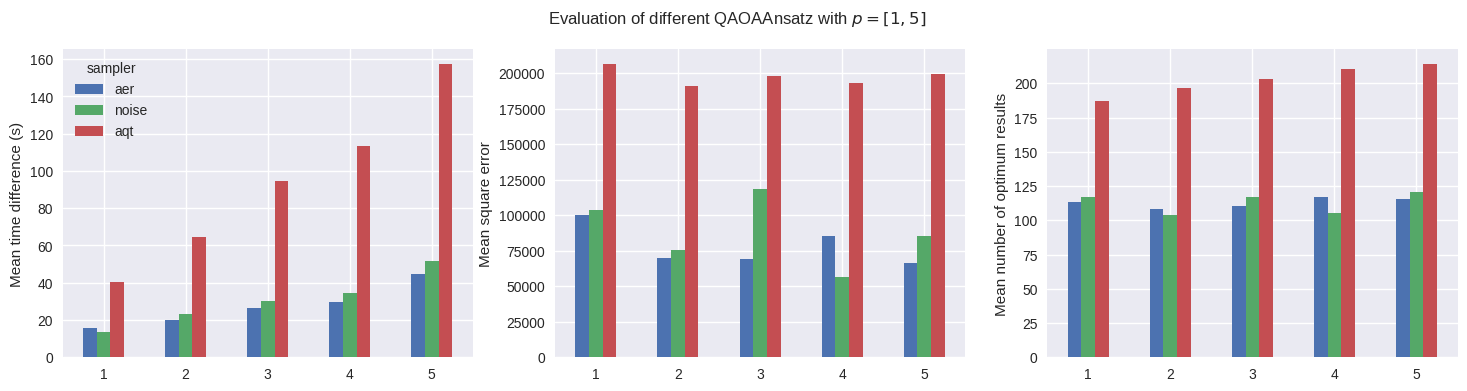

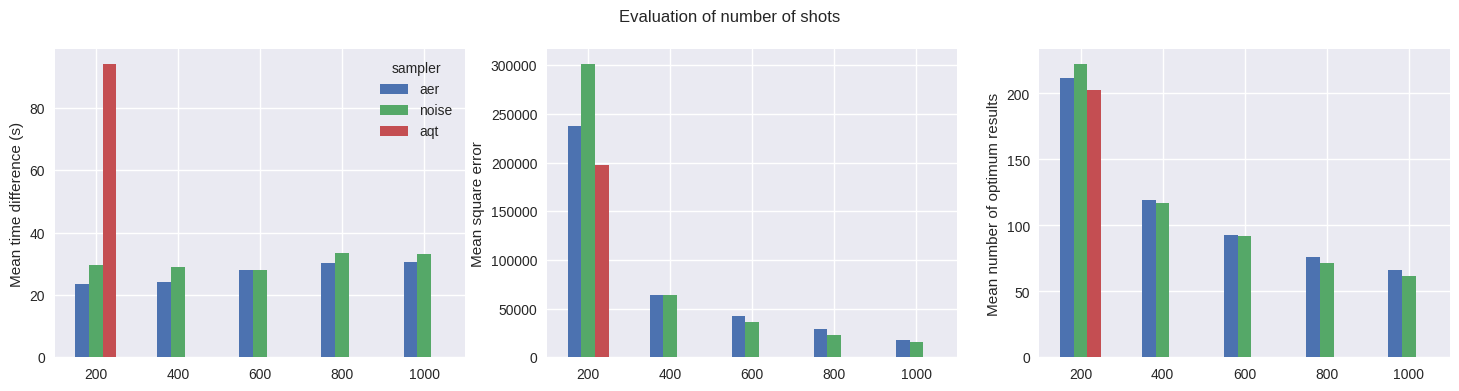

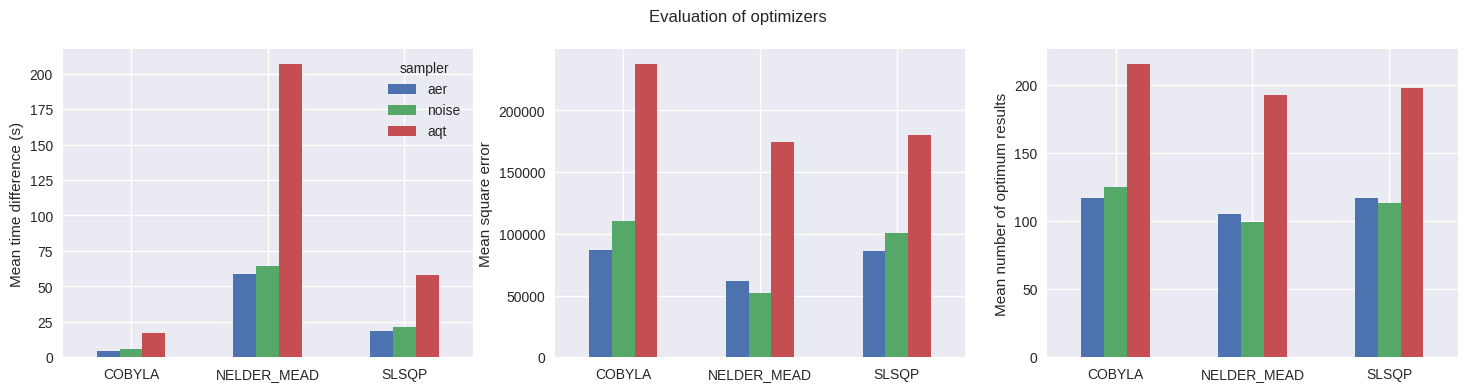

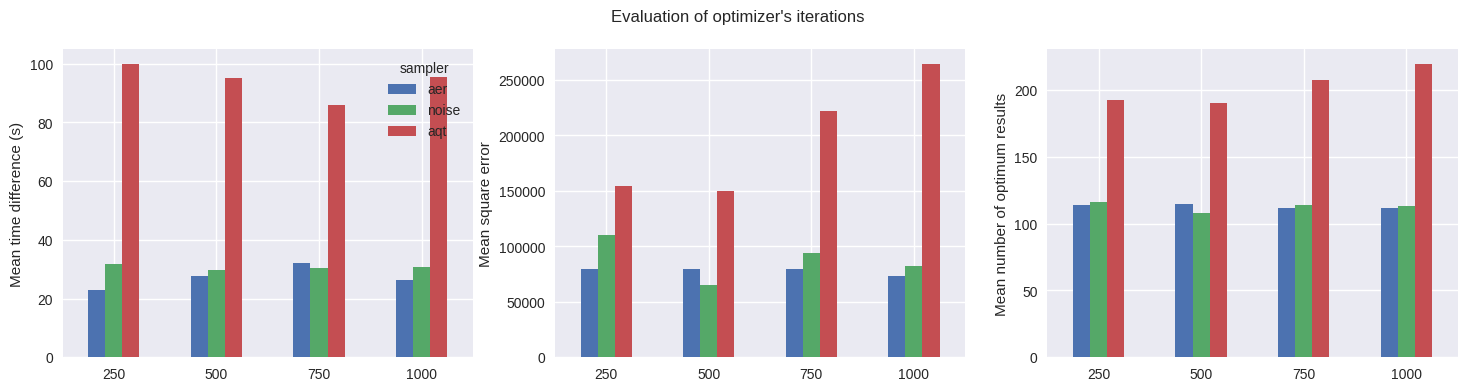

In [262]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

def plot(df, index, title, group="sampler"):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.suptitle(title)
    size = (18, 4)
    df.pivot_table(sort=False, values="time_difference", columns=[group], index=[index], aggfunc="mean").plot(kind="bar", rot=0, xlabel="", ylabel="Mean time difference (s)", ax=ax[0], figsize=size)
    df.pivot_table(sort=False, values="error", columns=[group], index=[index], aggfunc="mean").plot(kind="bar", rot=0, xlabel="", ylabel="Mean square error", ax=ax[1], figsize=size, legend=False)
    df.pivot_table(sort=False, values="optimum", columns=[group], index=[index], aggfunc="mean").plot(kind="bar", rot=0, xlabel="", ylabel="Mean number of optimum results", ax=ax[2], figsize=size, legend=False)

data = pd.read_csv('evaluation_data.csv')

plot(data, "p", "Evaluation of different QAOAAnsatz with $p=[1,5]$")
plot(data, "shots", "Evaluation of number of shots")
plot(data, "optimizer", "Evaluation of optimizers")
plot(data, "max_iter", "Evaluation of optimizer's iterations")